In [2]:
import numpy as np
import pandas as pd
import tensorflow.keras as keras
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input
from keras.layers import GlobalMaxPooling2D
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics.pairwise import linear_kernel
from glob import glob as glb

In [3]:
from google.colab import drive
drive.mount('/content/drive')
images_dir = '/content/drive/MyDrive/images'


Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/styles.csv')

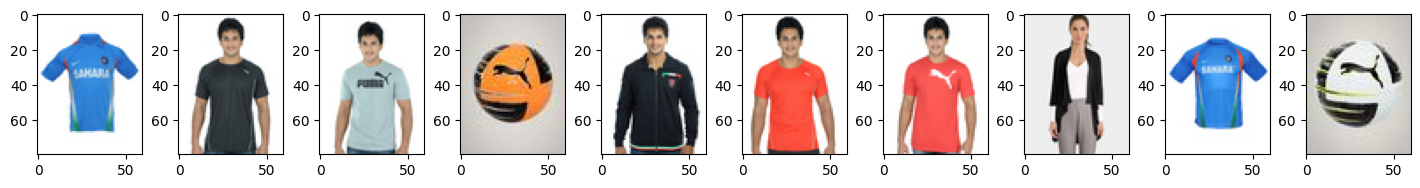

In [5]:
path=glb('/content/drive/MyDrive/images/*.jpg')
# Plot samples
plt.figure(figsize=(20,20))
for i in range(20,30):
    plt.subplot(6, 10, i-10+1)
    cloth_img =  mpimg.imread(path[i])
    plt.imshow(cloth_img)
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

In [6]:
styles_df = pd.read_csv("/content/drive/MyDrive/styles.csv", nrows=296)
styles_df['image'] = styles_df.apply(lambda x: str(x['id']) + ".jpg", axis=1)
print(styles_df.shape)
print(styles_df.head(5))

(295, 11)
     id  gender masterCategory subCategory articleType baseColour  season  \
0  1163     Men        Apparel     Topwear     Tshirts       Blue  Summer   
1  1164     Men        Apparel     Topwear     Tshirts       Blue  Winter   
2  1165     Men        Apparel     Topwear     Tshirts       Blue  Summer   
3  1525  Unisex    Accessories        Bags   Backpacks  Navy Blue    Fall   
4  1526  Unisex    Accessories        Bags   Backpacks      Black    Fall   

     year   usage                                productDisplayName     image  
0  2011.0  Sports  Nike Sahara Team India Fanwear Round Neck Jersey  1163.jpg  
1  2015.0  Sports           Nike Men Blue T20 Indian Cricket Jersey  1164.jpg  
2  2013.0  Sports               Nike Mean Team India Cricket Jersey  1165.jpg  
3  2010.0  Casual                      Puma Deck Navy Blue Backpack  1525.jpg  
4  2010.0  Sports                       Puma Big Cat Backpack Black  1526.jpg  


In [7]:
plt.figure(figsize=(7,20))

<Figure size 700x2000 with 0 Axes>

<Figure size 700x2000 with 0 Axes>

<Axes: ylabel='articleType'>

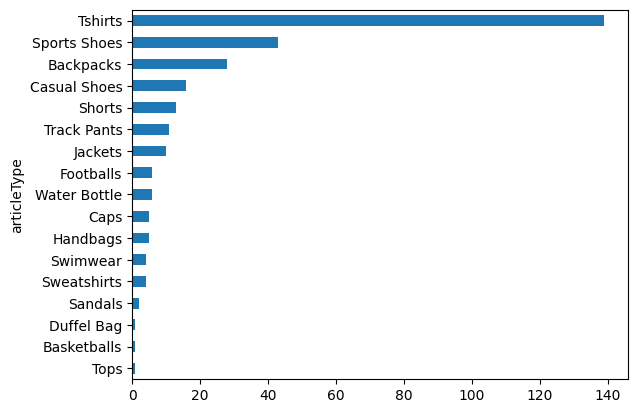

In [8]:
styles_df.articleType.value_counts().sort_values().plot(kind='barh')


In [9]:

img_width, img_height, chnls = 100, 100, 3

#VGG16
from tensorflow.keras.applications import VGG16

vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height, chnls))
vgg16.trainable=False
vgg16_model = keras.Sequential([vgg16, GlobalMaxPooling2D()])
vgg16_model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 global_max_pooling2d (Glob  (None, 512)               0         
 alMaxPooling2D)                                                 
                                                                 
Total params: 14714688 (56.13 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [10]:
def img_path(img):

    return '/content/drive/MyDrive/images/' + img

In [11]:
def predict(model, img_name):

    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    img = image.img_to_array(img)
    # Expand Dim (1, w, h)
    img = np.expand_dims(img, axis=0)
    # Pre process Input
    img = preprocess_input(img)
    return model.predict(img)

In [12]:
def get_embeddings(df, model):

    df_copy = df
    df_embeddings = df_copy['image'].apply(lambda x: predict(vgg16_model, x).reshape(-1))
    df_embeddings = df_embeddings.apply(pd.Series)
    return df_embeddings


1/1 [==============================] - 0s 117ms/step


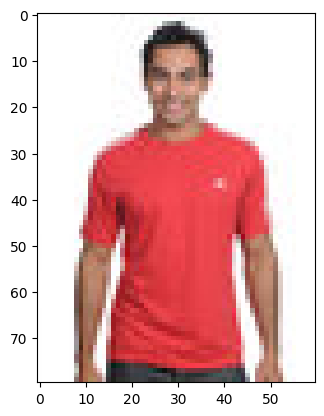

In [13]:
df_embeddings = get_embeddings(styles_df, vgg16_model)

url="/content/drive/MyDrive/images/1995.jpg"
a = plt.imread(url)
plt.imshow(a)

In [14]:
sample_image = predict(vgg16_model, '1995.jpg')
sample_image.shape

df_sample_image = pd.DataFrame(sample_image)
print(df_sample_image)

sample_similarity = linear_kernel(df_sample_image, df_embeddings)
print(sample_similarity)


1/1 [==============================] - 0s 132ms/step
   0    1    2    3        4    5    6    7    8    9    ...      502  \
0  0.0  0.0  0.0  0.0  0.11298  0.0  0.0  0.0  0.0  0.0  ...  0.01155   

        503  504  505  506       507  508  509       510       511  
0  3.750338  0.0  0.0  0.0  0.062523  0.0  0.0  0.539896  4.258632  

[1 rows x 512 columns]
[[353.926   327.16266 465.7373  303.47452 289.9326  604.2358  538.5324
  542.73193 486.3538  511.3055  660.3881  527.16034 394.67776 544.63165
  666.00696 482.15268 549.6025  597.51086 279.80692 287.16284 258.87915
  275.8245  291.09152 285.0409  279.61755 290.5314  294.14523 291.06888
  305.61948 272.46115 275.4265  323.8865  378.65543 347.70685 310.15982
  278.40292 282.018   393.76303 530.8181  539.0094  298.25076 416.63092
  352.11758 363.44772 452.63565 300.59113 306.4417  437.80392 524.4858
  481.12512 534.53375 573.9141  399.45874 419.71182 415.30612 486.2313
  439.37347 247.87846 506.18985 281.58902 302.4477  302.6901  277

In [15]:
def get_similarity(model):

    sample_image = predict(vgg16_model, '1995.jpg')
    df_sample_image = pd.DataFrame(sample_image)
    sample_similarity = linear_kernel(df_sample_image, df_embeddings)
    return sample_similarity


In [16]:
def normalize_sim(similarity):

    x_min = similarity.min(axis=1)
    x_max = similarity.max(axis=1)
    norm = (similarity-x_min)/(x_max-x_min)[:, np.newaxis]
    return norm

In [17]:
sample_similarity_norm = normalize_sim(sample_similarity)
sample_similarity_norm.shape
sample_similarity_norm

array([[0.23670456, 0.17696716, 0.48627424, 0.12409379, 0.09386737,
        0.7954112 , 0.64875734, 0.6581309 , 0.5322915 , 0.5879853 ,
        0.9207467 , 0.62337416, 0.327665  , 0.6623712 , 0.9332883 ,
        0.52291435, 0.6734664 , 0.7804008 , 0.07126626, 0.08768513,
        0.0245542 , 0.06237724, 0.09645419, 0.08294881, 0.07084358,
        0.09520397, 0.10327026, 0.09640364, 0.12888147, 0.05487006,
        0.06148893, 0.1696546 , 0.29190215, 0.22282305, 0.1390158 ,
        0.06813246, 0.07620154, 0.32562327, 0.63153857, 0.649822  ,
        0.11243404, 0.3766658 , 0.23266809, 0.25795764, 0.45703053,
        0.11765788, 0.13071674, 0.42392522, 0.6174044 , 0.52062076,
        0.6398321 , 0.72773147, 0.33833644, 0.38354254, 0.37370875,
        0.53201807, 0.42742854, 0.        , 0.5765668 , 0.07524402,
        0.12180185, 0.12234291, 0.06502516, 0.5212824 , 0.10217432,
        0.21481991, 0.18944438, 0.16889018, 0.7548042 , 0.19979265,
        0.22847813, 0.28628522, 0.2286021 , 0.35

In [18]:
def get_recommendations(df, similarity):


    sim_scores = list(enumerate(similarity[0]))


    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)


    sim_scores = sim_scores[0:5]
    print(sim_scores)

    cloth_indices = [i[0] for i in sim_scores]


    return df['image'].iloc[cloth_indices]

In [19]:
recommendation = get_recommendations(styles_df, sample_similarity_norm)
recommendation_list = recommendation.to_list()

[(290, 1.0), (219, 0.973908), (127, 0.93346256), (14, 0.9332883), (10, 0.9207467)]


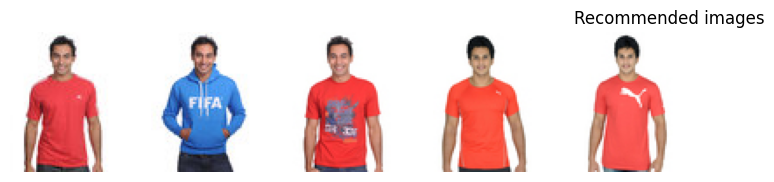

In [20]:

#recommended images
plt.figure(figsize=(20,20))
j=0
for i in recommendation_list:
    plt.subplot(6, 10, j+1)
    cloth_img =  mpimg.imread('/content/drive/MyDrive/images/'+ i)
    plt.imshow(cloth_img)
    plt.axis("off")
    j+=1
plt.title("Recommended images",loc='left')
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()